In [ ]:
#Mounting google and authenticating
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

Mounted at /content/gdrive


In [ ]:
!cp /mydrive/music\ project/X_spec_half.pickle ./
!cp /mydrive/music\ project/y_spec_half.pickle ./

In [ ]:
import pickle 
pickle_off = open("X_spec_half.pickle", 'rb')
X_spec = pickle.load(pickle_off)

pickle_off = open("y_spec_half.pickle", 'rb')
y_spec = pickle.load(pickle_off)

In [ ]:
X_spec_ = X_spec.reshape(48, 440, 128,1)
y_spec_ = y_spec.reshape(48, 440, 128, 1)

In [ ]:
X_spec_.shape

(48, 440, 128, 1)

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
#from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import Concatenate 
from tensorflow.keras.optimizers import Adam

In [ ]:
#Using encoding and decoding

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = Concatenate()([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = Concatenate()([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = Concatenate()([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = Concatenate()([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1))(c9)
    model = Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
im_width = 80
im_height = 128

input_img = Input((im_width, im_height, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss='mean_absolute_error', metrics=['accuracy'])


In [ ]:
results = model.fit(y_spec_, y_spec_, batch_size=32, epochs=10)

Epoch 1/10
2/2 [==============================] - 0s 36ms/step - loss: 38.8407 - accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 0s 37ms/step - loss: 38.7649 - accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 0s 33ms/step - loss: 38.6897 - accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 0s 24ms/step - loss: 38.6159 - accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 0s 26ms/step - loss: 38.5395 - accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 0s 27ms/step - loss: 38.4731 - accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 0s 24ms/step - loss: 38.4138 - accuracy: 0.0000e+00
Epoch 8/10
2/2 [==============================] - 0s 23ms/step - loss: 38.3603 - accuracy: 0.0000e+00
Epoch 9/10
2/2 [==============================] - 0s 26ms/step - loss: 38.3134 - accuracy: 0.0000e+00
Epoch 10/10
2/2 [==============================] - 0s 23ms/step - loss: 38.2725 - 

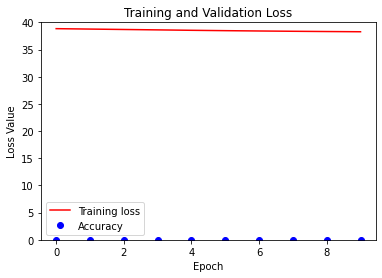

In [ ]:
import matplotlib.pyplot as plt

Epochs = 10
train_loss = results.history['loss']
train_accuracy = results.history['accuracy']

epochs = range(Epochs)

plt.figure()
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, train_accuracy, 'bo', label='Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 40])
plt.legend()
plt.show()


In [ ]:
X_spec_ = X_spec_.reshape(-1,1)
y_spec_ = y_spec_.reshape(-1,1)

In [ ]:
#Using Random Forest
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_spec_, y_spec_)

#print(regr.predict([[0, 0, 0, 0]]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
#R square
regr.score(X_spec_, y_spec_)

0.3967978758216605

In [ ]:
#Using regressor sequential
from tensorflow import keras
from tensorflow.keras import layers

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(X_spec_
                            )

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

In [ ]:
import tensorflow as tf
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanSquaredError()])

history = horsepower_model.fit(
    X_spec_, y_spec_,
    epochs=5,
    # suppress logging
    #verbose=0,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/5
76032/76032 [==============================] - 117s 2ms/step - loss: 10.2469 - mean_squared_error: 186.6453 - val_loss: 8.7888 - val_mean_squared_error: 126.8809
Epoch 2/5
76032/76032 [==============================] - 116s 2ms/step - loss: 9.7955 - mean_squared_error: 165.4883 - val_loss: 8.7916 - val_mean_squared_error: 126.2527
Epoch 3/5
76032/76032 [==============================] - 117s 2ms/step - loss: 9.7876 - mean_squared_error: 165.1230 - val_loss: 8.8311 - val_mean_squared_error: 127.3049
Epoch 4/5
76032/76032 [==============================] - 117s 2ms/step - loss: 9.8009 - mean_squared_error: 165.6078 - val_loss: 8.7863 - val_mean_squared_error: 126.4755
Epoch 5/5
76032/76032 [==============================] - 117s 2ms/step - loss: 9.7931 - mean_squared_error: 165.4911 - val_loss: 8.7642 - val_mean_squared_error: 125.6438


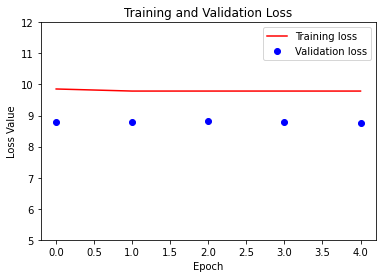

In [ ]:
import matplotlib.pyplot as plt

Epochs = 5
train_loss = history.history['loss']
train_accuracy = history.history['val_loss']

epochs = range(Epochs)

plt.figure()
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, train_accuracy, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([5, 12])
plt.legend()
plt.show()

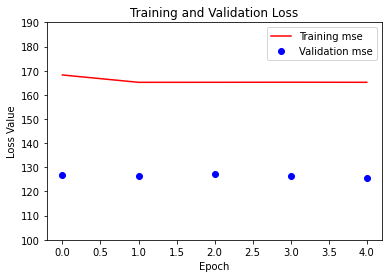

In [ ]:
import matplotlib.pyplot as plt

Epochs = 5
train_loss = history.history['mean_squared_error']
train_accuracy = history.history['val_mean_squared_error']

epochs = range(Epochs)

plt.figure()
plt.plot(epochs, train_loss, 'r', label='Training mse')
plt.plot(epochs, train_accuracy, 'bo', label='Validation mse')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([100, 190])
plt.legend()
plt.show()